## 特徴量ごとの性能を見る

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import math
import operator
import multiprocessing
import numpy as np
import pandas as pd
from scipy import interp
from patsy import dmatrices
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [79]:
def monthStrToNum(monthStr):
    return int(datetime.datetime.strptime(monthStr, '%b').date().strftime('%m'))

df['month_num'] = np.vectorize(monthStrToNum)(df['month'])

In [3]:
def getDayOfYear(month, day): # ex. month = "mar", day = 15
    return int(datetime.datetime.strptime("{} {}".format(month, day), '%b %d').date().strftime('%j'))

df['dayofyear'] = np.vectorize(getDayOfYear)(df['month'], df['day'])
df['dayofweek'] = df['dayofyear'] % 7

In [4]:
def getPDayOfWeek(pdays):
    return -1 if pdays == -1 else pdays % 7

df['pdayofweek'] = np.vectorize(getPDayOfWeek)(df['pdays'])

In [5]:
def logBigNum(num):
    return int(num) if num < 2 else int(math.log(num, 1.1))

df['balance_log'] = np.vectorize(logBigNum)(df['balance'])
df['duration_log'] = np.vectorize(logBigNum)(df['duration'])
df['pdays_log'] = np.vectorize(logBigNum)(df['pdays'])

In [6]:
df['balance_div10'] = (df['balance'] / 10).astype(int)

## 特徴量ごとに、学習データとバリデーションデータのAUCを比較する

In [7]:
train_df, valid_df = train_test_split(df)

In [8]:
def evaluate_feature(feature_str, classifiers):
    
    y, X = dmatrices(feature_str, data=train_df, return_type='dataframe')
    X_train = X.values
    y_train = y.y.values
    
    y, X = dmatrices(feature_str, data=valid_df, return_type='dataframe')
    X_valid = X.values
    y_valid = y.y.values
    
    for classifier in classifiers:
        print(type(classifier).__name__.ljust(50), end="\t")
        classifier.fit(X_train, y_train)
        
        probas_train = classifier.predict_proba(X_train)[:, 1]
        print("train: {0:.5f}".format(roc_auc_score(y_train, probas_train)), end="\t")
        
        probas_valid = classifier.predict_proba(X_valid)[:, 1]
        print("valid: {0:.5f}".format(roc_auc_score(y_valid, probas_valid)))

In [9]:
ada_model = AdaBoostClassifier(n_estimators=500)
gbdt_model = GradientBoostingClassifier(n_estimators=500)
rf_model = RandomForestClassifier(n_estimators=2000, n_jobs=multiprocessing.cpu_count())

models = [ada_model, gbdt_model, rf_model]

features = ['age', 'balance', 'balance_log', 'balance_div10', 'dayofyear', 'dayofweek', 'duration', 'duration_log', 'campaign', 'pdays', 'pdays_log', 'pdayofweek', 'previous']

In [10]:
for feature in features:
    print(feature)
    evaluate_feature('y ~ {}'.format(feature), models)
    print('')

age
AdaBoostClassifier                                	train: 0.60508	valid: 0.59455
GradientBoostingClassifier                        	train: 0.60536	valid: 0.59301
RandomForestClassifier                            	train: 0.60526	valid: 0.59277

balance
AdaBoostClassifier                                	train: 0.63211	valid: 0.57722
GradientBoostingClassifier                        	train: 0.72668	valid: 0.59009
RandomForestClassifier                            	train: 0.87919	valid: 0.57112

balance_log
AdaBoostClassifier                                	train: 0.61232	valid: 0.57813
GradientBoostingClassifier                        	train: 0.63557	valid: 0.58086
RandomForestClassifier                            	train: 0.63765	valid: 0.57730

balance_div10
AdaBoostClassifier                                	train: 0.62701	valid: 0.57871
GradientBoostingClassifier                        	train: 0.67613	valid: 0.57542
RandomForestClassifier                            	train: 0.70983	va

In [62]:
def feature_importances_(xbg_model, columns):
    b = xbg_model.booster()
    fs = b.get_fscore()
    importance = sorted(fs.items(), key=operator.itemgetter(1))
    importance = list(map(lambda a: [columns[int(a[0][1:])], a[1]], importance))
        
    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()
    return df

In [73]:
def xgb_feature_importances(feature_str, xgb_model):
    
    y, X = dmatrices(feature_str, data=train_df, return_type='dataframe')
    X_train = X.values
    y_train = y.y.values
    
    y, X = dmatrices(feature_str, data=valid_df, return_type='dataframe')
    X_valid = X.values
    y_valid = y.y.values
    
    xgb_model.fit(X_train, y_train)
    
    probas_train = xgb_model.predict_proba(X_train)[:, 1]
    print("train: {0:.5f}".format(roc_auc_score(y_train, probas_train)), end="\t")

    probas_valid = xgb_model.predict_proba(X_valid)[:, 1]
    print("valid: {0:.5f}".format(roc_auc_score(y_valid, probas_valid)))
    
    feature_importances = feature_importances_(xgb_model, X.columns)

    plt.figure()
    feature_importances.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')

train: 0.95775	valid: 0.93044


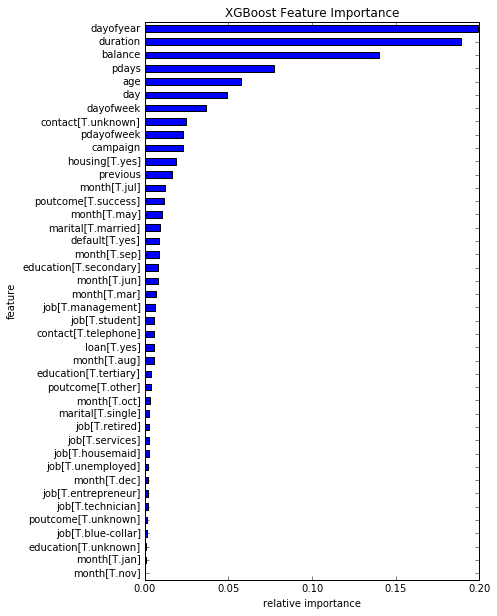

In [75]:
xgb_model = XGBClassifier(n_estimators=500, max_depth=3, gamma=0, min_child_weight=10)
xgb_feature_importances('y ~ age + job + marital + education + default + balance + housing + loan + contact + day + month + dayofyear + dayofweek + duration + campaign + pdays + pdayofweek + previous + poutcome', xgb_model)

train: 0.95664	valid: 0.92936


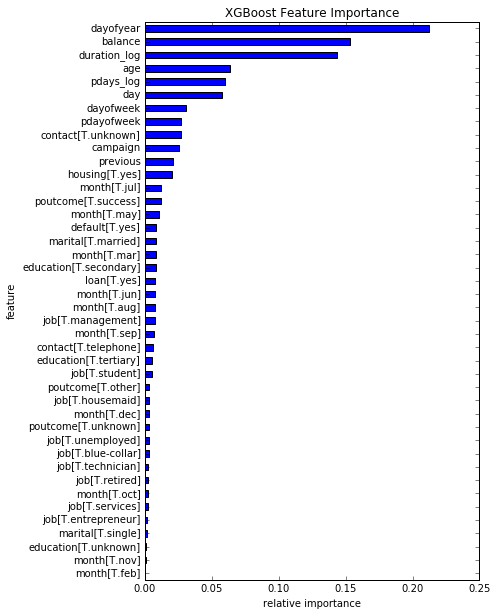

In [76]:
xgb_model = XGBClassifier(n_estimators=500, max_depth=3, gamma=0, min_child_weight=10)
xgb_feature_importances('y ~ age + job + marital + education + default + balance + housing + loan + contact + day + month + dayofyear + dayofweek + duration_log + campaign + pdays_log + pdayofweek + previous + poutcome', xgb_model)

### 考察

RandomForestで、balanceとdurationがoverfitする。
logを取った後に整数にするとマシになる。